In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
from tensorflow.keras.applications import VGG16,InceptionResNetV2,InceptionV3,ResNet50,ResNet152V2,MobileNetV2,ResNet101,Xception,VGG19,MobileNet,DenseNet201,NASNetMobile,DenseNet169,MobileNet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2,Xception,EfficientNetB0,EfficientNetB7,NASNetLarge,ResNet152V2,EfficientNetV2L,EfficientNetV2M 
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
import os

folder_path = '/data/ahsan/additive3d/result1/adam'

# Check if the folder exists
if os.path.exists(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Loop through the files and remove them
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Removed: {file_path}")
            else:
                print(f"Skipped: {file_path} (not a file)")
        except Exception as e:
            print(f"Error removing {file_path}: {str(e)}")
else:
    print(f"The folder '{folder_path}' does not exist.")


Removed: /data/ahsan/additive3d/result1/rmsprop/vgg16model_results.xlsx
Removed: /data/ahsan/additive3d/result1/rmsprop/vggROC.png
Removed: /data/ahsan/additive3d/result1/rmsprop/vggACC.png
Removed: /data/ahsan/additive3d/result1/rmsprop/prACC.png
Removed: /data/ahsan/additive3d/result1/rmsprop/Inceptionresnetmodel_results.xlsx
Removed: /data/ahsan/additive3d/result1/rmsprop/inceptROC.png
Removed: /data/ahsan/additive3d/result1/rmsprop/inceptACC.png
Removed: /data/ahsan/additive3d/result1/rmsprop/inceptPR.png
Removed: /data/ahsan/additive3d/result1/rmsprop/resnet50model_results.xlsx
Removed: /data/ahsan/additive3d/result1/rmsprop/res50roc.png
Removed: /data/ahsan/additive3d/result1/rmsprop/res50acc.png
Removed: /data/ahsan/additive3d/result1/rmsprop/res50pr.png
Removed: /data/ahsan/additive3d/result1/rmsprop/res101roc.png
Removed: /data/ahsan/additive3d/result1/rmsprop/res101acc.png
Removed: /data/ahsan/additive3d/result1/rmsprop/res101pr.png
Removed: /data/ahsan/additive3d/result1/rms

In [2]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,SeparableConv2D,GlobalAveragePooling2D
from keras.regularizers import l1

In [3]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [4]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 30

In [5]:
print("[INFO] loading images...")
#imagePaths =list(paths.list_images(r"C:\Users\dvv3455\data\Experiment2-20240322T005256Z-001\Experiment2"))
imagePaths =list(paths.list_images(r"C:\Users\dvv3455\data\Experiment3-20240322T171146Z-001\Experiment3"))
data = []
labels = []

[INFO] loading images...


In [6]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# Assuming you have 'data' and 'labels' already defined

# Convert labels to one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split the data into training, validation, and testing sets
(trainX, tempX, trainY, tempY) = train_test_split(data, labels, test_size=0.3, random_state=42)
(validationX, testX, validationY, testY) = train_test_split(tempX, tempY, test_size=0.66, random_state=42)

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

# Print the number of samples and their ratios in each set
total_samples = len(data)
train_samples = len(trainX)
validation_samples = len(validationX)
test_samples = len(testX)

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples * 100:.2f}%)")
print(f"Validation samples: {validation_samples} ({validation_samples / total_samples * 100:.2f}%)")
print(f"Testing samples: {test_samples} ({test_samples / total_samples * 100:.2f}%)")


Total samples: 3017
Training samples: 2111 (69.97%)
Validation samples: 308 (10.21%)
Testing samples: 598 (19.82%)


VGG16

In [8]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off

baseModel =VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model



In [9]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
opt = RMSprop(learning_rate=0.001)

[INFO] Compiling model...


In [10]:
# Assuming INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, and model are already defined
INIT_LR = 0.001  # Example learning rate
EPOCHS = 50
BS = 30  # Batch size

In [11]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined

# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])



[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
71/71 [==============================] - 23s 211ms/step - loss: 0.4553 - accuracy: 0.8072 - val_loss: 0.2630 - val_accuracy: 0.9091
Epoch 2/50
71/71 [==============================] - 10s 145ms/step - loss: 0.2188 - accuracy: 0.9403 - val_loss: 0.1419 - val_accuracy: 0.9481
Epoch 3/50
71/71 [==============================] - 10s 146ms/step - loss: 0.1360 - accuracy: 0.9626 - val_loss: 0.0905 - val_accuracy: 0.9805
Epoch 4/50
71/71 [==============================] - 10s 147ms/step - loss: 0.0981 - accuracy: 0.9777 - val_loss: 0.0686 - val_accuracy: 0.9740
Epoch 5/50
71/71 [==============================] - 11s 160ms/step - loss: 0.0829 - accuracy: 0.9829 - val_loss: 0.0522 - val_accuracy: 0.9903
Epoch 6/50
71/71 [==============================] - 10s 147ms/step - loss: 0.0687 - accuracy: 0.9863 - val_loss: 0.0405 - val_accuracy: 0.9903
Epoch 7/50
71/71 [==============================] - 10s 146ms/step

OSError: Cannot save file into a non-existent directory: 'C:\Users\dvv3455\data\result\rmsprop'

In [12]:
# Save to Excel
with pd.ExcelWriter('C:/Users/dvv3455/data/result/vgg16model_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")

Results saved to model_results.xlsx


In [13]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      0.92      0.96        98
goodcylinder       0.92      1.00      0.96        92

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190



In [14]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[90  8]
 [ 0 92]]
acc: 0.9579
sensitivity: 0.9184
specificity: 1.0000


In [15]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...


2/2 [==============================] - 1s 742ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      0.96      0.98        27
goodcylinder       0.97      1.00      0.98        28

    accuracy                           0.98        55
   macro avg       0.98      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55



In [16]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[26  1]
 [ 0 28]]
acc: 0.9818
sensitivity: 0.9630
specificity: 1.0000


In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        11
goodcylinder       1.00      1.00      1.00        16

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [18]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[11  0]
 [ 0 16]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [19]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 18ms/step

Training Metrics:
Accuracy: 0.9578947368421052
Precision: 0.92
Recall: 1.0
F1 Score: 0.9583333333333334
MCC: 0.9191833109797379
Kappa: 0.915929203539823
AUC: 1.0
mAP: 1.0

Validation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 0.9818181818181818
Precision: 0.9655172413793104
Recall: 1.0
F1 Score: 0.9824561403508771
MCC: 0.9642392563832106
Kappa: 0.9636002647253474
AUC: 1.0
mAP: 0.9999999999999999


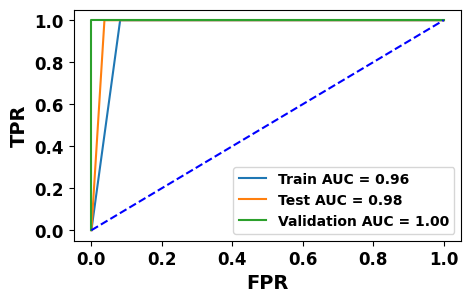

In [20]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
#plt.legend(prop={'size': 12})
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/vggROC.png', dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

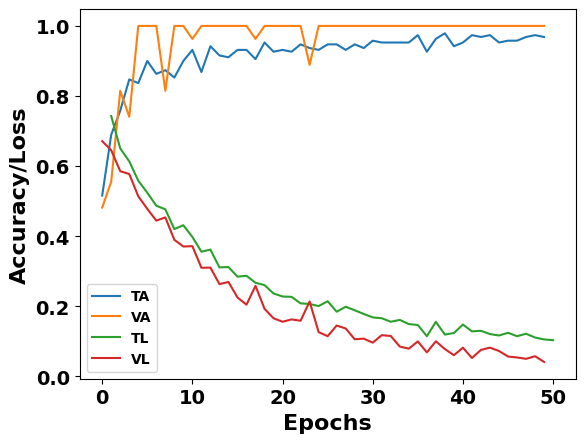

In [21]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/vggACC',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 41ms/step


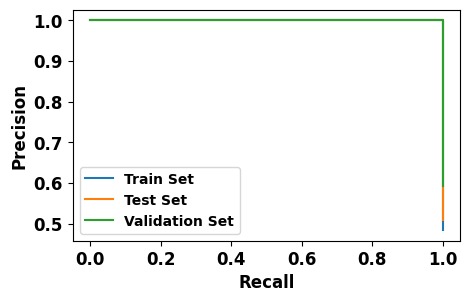

In [22]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/prACC',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


#Flops calculation


#Capsul Network demo

# Statistical significant test


In [23]:
# import scipy.stats

# #find T critical value
# scipy.stats.t.ppf(q=1-.05/2,df=6)

In [24]:
#  # paired student's t-test
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import ttest_rel
# from numpy import std
# import statistics
# # seed the random number generator
# seed(1)
# # generate two independent samples
# #data1 = [0.17, .16, .15, .26, 0.47, 0.05, 44.63, 0.0915]
# #data2 = [0.19, 0.11, 0.12, 0.26,0.40, 0.05, 36.83, 0.06]
# data1 = [0.17]
# data2 = [0.19]

# x1 = statistics.mean(data1)
# x2 = statistics.mean(data2)
# print("mean without SMOTE:", x1)
# print("mean with SMOTE:", x2)
# print("paried difference:", x1-x2)
# result1 = std(data1)
# result2= std(data2)
# print('Standard Deviation without SMOTE: % .3f' % result1)
# print('Standard Deviation after SMOTE: % .3f' % result2)
# print("SD difference:", result1-result2)
# # compare samples
# stat, p = ttest_rel(data1, data2)
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
#   print('Same distributions (fail to reject H0)')
# else:
#   print('Different distributions (reject H0)')

In [25]:
# # calculating SEM
# from scipy.stats import sem
# SEM1= sem(data1)
# SEM2= sem(data2)

# print("SEM without SMOTE:", SEM1)
# print("SEM with SMOTE:", SEM2)
# print("SEM difference:", SEM1-SEM2)


In [26]:
# # binomial confidence interval
# from math import sqrt
# # calculate the interval
# interval = (1.96 * sqrt( (0.2 * (1 - 0.41)) / 16))
# print('%.3f' % interval)
# print('%.3f' % (interval*100))

In [27]:
# from statsmodels.stats.proportion import proportion_confint
# # calculate the interval
# lower, upper = proportion_confint(574, 604, 0.05)
# print('lower=%.3f, upper=%.3f' % (lower, upper))

InceptionResnet


In [28]:
baseModel =InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
opt = SGD(learning_rate=INIT_LR)

[INFO] Compiling model...


In [30]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined

# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/Inceptionresnetmodel_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...


Epoch 1/50
7/7 [==============================] - 22s 1s/step - loss: 0.5543 - accuracy: 0.7632 - val_loss: 0.1337 - val_accuracy: 1.0000
Epoch 2/50
7/7 [==============================] - 1s 73ms/step - loss: 0.2541 - accuracy: 0.9000 - val_loss: 0.1178 - val_accuracy: 1.0000
Epoch 3/50
7/7 [==============================] - 0s 65ms/step - loss: 0.1351 - accuracy: 0.9579 - val_loss: 0.0642 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 0s 67ms/step - loss: 0.1128 - accuracy: 0.9789 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 1s 76ms/step - loss: 0.1139 - accuracy: 0.9526 - val_loss: 0.1076 - val_accuracy: 0.9259
Epoch 6/50
7/7 [==============================] - 1s 74ms/step - loss: 0.0888 - accuracy: 0.9684 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 70ms/step - loss: 0.0892 - accuracy: 0.9632 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 8/50
7/7 [============

In [31]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        98
goodcylinder       1.00      1.00      1.00        92

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [32]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [ 0 92]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [33]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 1s 675ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        27
goodcylinder       1.00      1.00      1.00        28

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55

[[27  0]
 [ 0 28]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
[INFO] evaluating network...
1/1 [==============================] - 0s 77ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        11
goodcylinder       1.00      1.00      1.00        16

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

[[11  0]
 [ 0 16]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [34]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 32ms/step

Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Validation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0


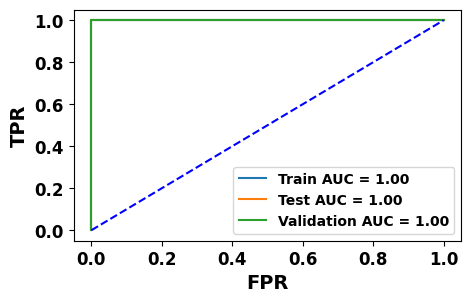

In [35]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/inceptROC.png',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

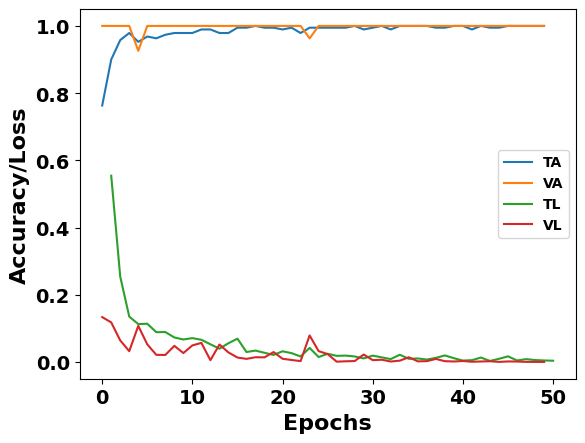

In [36]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/inceptACC',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 77ms/step


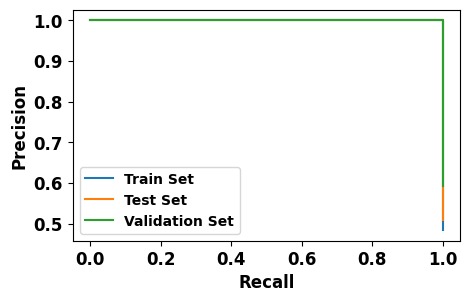

In [37]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/inceptPR',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


ResNet50

In [38]:
baseModel =ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [39]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/resnet50model_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/50


7/7 [==============================] - 7s 363ms/step - loss: 0.7901 - accuracy: 0.5211 - val_loss: 0.7807 - val_accuracy: 0.4074
Epoch 2/50
7/7 [==============================] - 0s 34ms/step - loss: 0.7464 - accuracy: 0.4526 - val_loss: 0.6841 - val_accuracy: 0.5926
Epoch 3/50
7/7 [==============================] - 0s 35ms/step - loss: 0.7030 - accuracy: 0.5526 - val_loss: 0.6824 - val_accuracy: 0.5926
Epoch 4/50
7/7 [==============================] - 0s 38ms/step - loss: 0.6964 - accuracy: 0.4947 - val_loss: 0.6916 - val_accuracy: 0.4074
Epoch 5/50
7/7 [==============================] - 0s 38ms/step - loss: 0.6894 - accuracy: 0.5158 - val_loss: 0.7021 - val_accuracy: 0.4074
Epoch 6/50
7/7 [==============================] - 0s 36ms/step - loss: 0.6880 - accuracy: 0.5737 - val_loss: 0.7040 - val_accuracy: 0.4074
Epoch 7/50
7/7 [==============================] - 0s 38ms/step - loss: 0.6968 - accuracy: 0.5421 - val_loss: 0.6980 - val_accuracy: 0.4074
Epoch 8/50
7/7 [=====================

In [40]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

 badcylinder       0.73      1.00      0.84        98
goodcylinder       1.00      0.61      0.76        92

    accuracy                           0.81       190
   macro avg       0.87      0.80      0.80       190
weighted avg       0.86      0.81      0.80       190



In [41]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [36 56]]
acc: 0.8105
sensitivity: 1.0000
specificity: 0.6087


In [42]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 0s 375ms/step
              precision    recall  f1-score   support

 badcylinder       0.77      1.00      0.87        27
goodcylinder       1.00      0.71      0.83        28

    accuracy                           0.85        55
   macro avg       0.89      0.86      0.85        55
weighted avg       0.89      0.85      0.85        55

[[27  0]
 [ 8 20]]
acc: 0.8545
sensitivity: 1.0000
specificity: 0.7143
[INFO] evaluating network...
1/1 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

 badcylinder       0.61      1.00      0.76        11
goodcylinder       1.00      0.56      0.72        16

    accuracy                           0.74        27
   macro avg       0.81      0.78      0.74        27
weighted avg       0.84      0.74      0.74        27

[[11  0]
 [ 7  9]]
acc: 0.7407
sensitivity: 1.0000
specificity: 0.5625


In [43]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 16ms/step

Training Metrics:
Accuracy: 0.8105263157894737
Precision: 1.0
Recall: 0.6086956521739131
F1 Score: 0.7567567567567568
MCC: 0.6672072219056168
Kappa: 0.6160754378087112
AUC: 0.9957852706299911
mAP: 0.9956873229242825

Validation Metrics:
Accuracy: 0.7407407407407407
Precision: 1.0
Recall: 0.5625
F1 Score: 0.72
MCC: 0.5863019699779286
Kappa: 0.5116279069767442
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 0.8545454545454545
Precision: 1.0
Recall: 0.7142857142857143
F1 Score: 0.8333333333333333
MCC: 0.7423074889580903
Kappa: 0.7105263157894737
AUC: 1.0
mAP: 0.9999999999999999


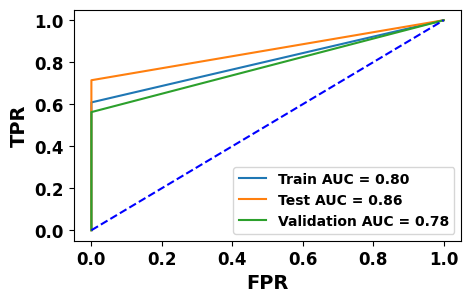

In [44]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/res50roc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

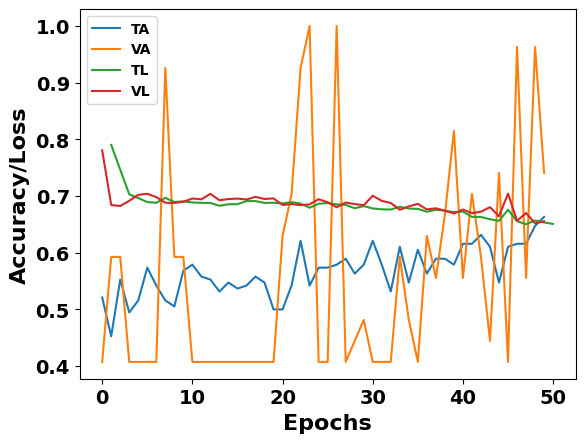

In [45]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/res50acc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 44ms/step


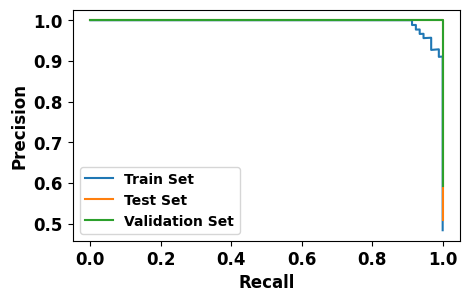

In [46]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})

plt.savefig('/data/ahsan/additive3d/result1/rmsprop/res50pr',dpi=200, bbox_inches='tight')
# Show plot
plt.show()


ResNet101

In [47]:
baseModel =ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [48]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/resnet101model_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
7/7 [==============================] - 12s 603ms/step - loss: 0.7762 - accuracy: 0.5000 - val_loss: 0.7478 - val_accuracy: 0.4074
Epoch 2/50
7/7 [==============================] - 0s 60ms/step - loss: 0.6884 - accuracy: 0.5579 - val_loss: 0.6639 - val_accuracy: 0.5926
Epoch 3/50
7/7 [==============================] - 0s 59ms/step - loss: 0.6954 - accuracy: 0.5526 - val_loss: 0.6612 - val_accuracy: 0.5926
Epoch 4/50
7/7 [==============================] - 0s 59ms/step - loss: 0.6804 - accuracy: 0.5737 - val_loss: 0.6570 - val_accuracy: 0.5926
Epoch 5/50
7/7 [==============================] - 0s 65ms/step - loss: 0.6868 - accuracy: 0.5474 - val_loss: 0.6677 - val_accuracy: 0.6667
Epoch 6/50
7/7 [==============================] - 0s 72ms/step - loss: 0.6808 - accuracy: 0.5211 - val_loss: 0.6705 - val_accuracy: 0.7037
Epoch 7/50
7/7 [==============================] - 0s 64ms/step - loss: 0.6732 - accuracy

In [49]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

 badcylinder       0.73      1.00      0.84        98
goodcylinder       1.00      0.60      0.75        92

    accuracy                           0.81       190
   macro avg       0.86      0.80      0.79       190
weighted avg       0.86      0.81      0.80       190



In [50]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [37 55]]
acc: 0.8053
sensitivity: 1.0000
specificity: 0.5978


In [51]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

 badcylinder       0.73      1.00      0.84        98
goodcylinder       1.00      0.60      0.75        92

    accuracy                           0.81       190
   macro avg       0.86      0.80      0.79       190
weighted avg       0.86      0.81      0.80       190



In [52]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [37 55]]
acc: 0.8053
sensitivity: 1.0000
specificity: 0.5978


In [53]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

 badcylinder       0.75      1.00      0.86        27
goodcylinder       1.00      0.68      0.81        28

    accuracy                           0.84        55
   macro avg       0.88      0.84      0.83        55
weighted avg       0.88      0.84      0.83        55

[[27  0]
 [ 9 19]]
acc: 0.8364
sensitivity: 1.0000
specificity: 0.6786
[INFO] evaluating network...
1/1 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

 badcylinder       0.61      1.00      0.76        11
goodcylinder       1.00      0.56      0.72        16

    accuracy                           0.74        27
   macro avg       0.81      0.78      0.74        27
weighted avg       0.84      0.74      0.74        27

[[11  0]
 [ 7  9]]
acc: 0.7407
sensitivity: 1.0000
specificity: 0.5625


In [54]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 22ms/step

Training Metrics:
Accuracy: 0.8052631578947368
Precision: 1.0
Recall: 0.5978260869565217
F1 Score: 0.7482993197278911
MCC: 0.6587696530021598
Kappa: 0.605277933745087
AUC: 0.9088287488908607
mAP: 0.9277547541767266

Validation Metrics:
Accuracy: 0.7407407407407407
Precision: 1.0
Recall: 0.5625
F1 Score: 0.72
MCC: 0.5863019699779286
Kappa: 0.5116279069767442
AUC: 0.875
mAP: 0.9212509970249909

Test Metrics:
Accuracy: 0.8363636363636363
Precision: 1.0
Recall: 0.6785714285714286
F1 Score: 0.8085106382978724
MCC: 0.7133922984085064
Kappa: 0.6745562130177515
AUC: 0.9563492063492065
mAP: 0.9669342645714597


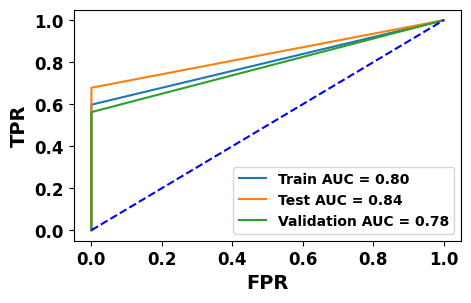

In [55]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/res101roc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

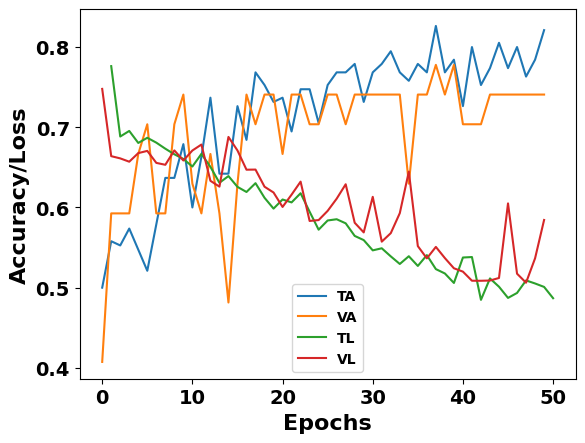

In [56]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/res101acc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 66ms/step


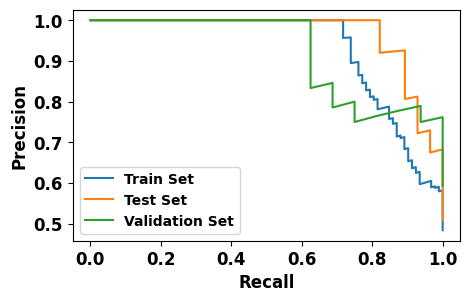

In [57]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/res101pr',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


MobileNetV2

In [58]:

baseModel =MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [59]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/mobilenetmodel_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/50


7/7 [==============================] - 5s 223ms/step - loss: 0.4183 - accuracy: 0.8105 - val_loss: 0.0708 - val_accuracy: 1.0000
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0819 - accuracy: 0.9947 - val_loss: 0.0338 - val_accuracy: 1.0000
Epoch 3/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0531 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0439 - accuracy: 0.9895 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 0s 31ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/50
7/7 [=====================

In [60]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        98
goodcylinder       1.00      1.00      1.00        92

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [61]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [ 0 92]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [62]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 0s 39ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        27
goodcylinder       1.00      1.00      1.00        28

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55

[[27  0]
 [ 0 28]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
[INFO] evaluating network...
1/1 [==============================] - 0s 58ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        11
goodcylinder       1.00      1.00      1.00        16

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

[[11  0]
 [ 0 16]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [63]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 14ms/step

Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Validation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0


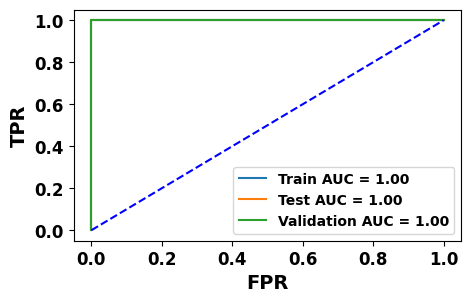

In [64]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/mobileroc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

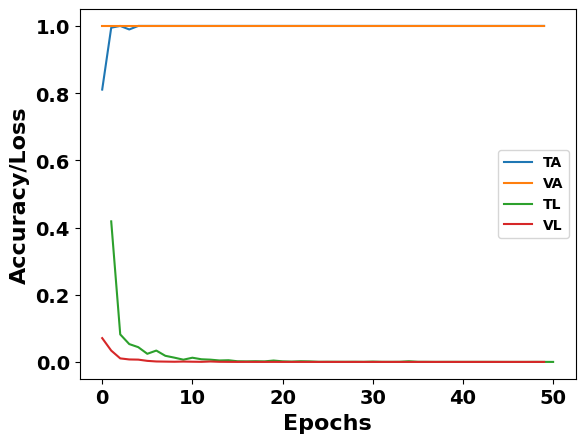

In [65]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/mobileacc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 44ms/step


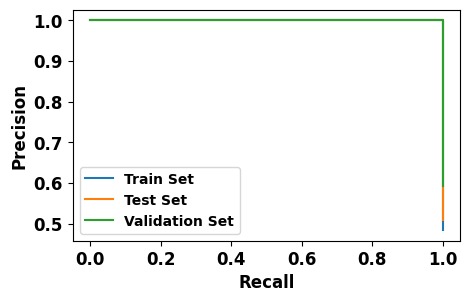

In [66]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/mobilepr',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


VGG19

In [67]:

baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [68]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
opt = SGD(learning_rate=INIT_LR)

[INFO] Compiling model...


In [69]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/vgg19model_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
7/7 [==============================] - 2s 122ms/step - loss: 0.7111 - accuracy: 0.5105 - val_loss: 0.5925 - val_accuracy: 0.7037
Epoch 2/50
7/7 [==============================] - 0s 45ms/step - loss: 0.5810 - accuracy: 0.7526 - val_loss: 0.5551 - val_accuracy: 1.0000
Epoch 3/50
7/7 [==============================] - 0s 44ms/step - loss: 0.5422 - accuracy: 0.7842 - val_loss: 0.5057 - val_accuracy: 0.9630
Epoch 4/50
7/7 [==============================] - 0s 43ms/step - loss: 0.4912 - accuracy: 0.8368 - val_loss: 0.4802 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 0s 44ms/step - loss: 0.4548 - accuracy: 0.8579 - val_loss: 0.4335 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 43ms/step - loss: 0.3942 - accuracy: 0.8895 - val_loss: 0.4166 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 46ms/step - loss: 0.4039 - accuracy:

In [70]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

 badcylinder       0.93      1.00      0.97        98
goodcylinder       1.00      0.92      0.96        92

    accuracy                           0.96       190
   macro avg       0.97      0.96      0.96       190
weighted avg       0.97      0.96      0.96       190



In [71]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [ 7 85]]
acc: 0.9632
sensitivity: 1.0000
specificity: 0.9239


In [72]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

 badcylinder       0.93      1.00      0.96        27
goodcylinder       1.00      0.93      0.96        28

    accuracy                           0.96        55
   macro avg       0.97      0.96      0.96        55
weighted avg       0.97      0.96      0.96        55

[[27  0]
 [ 2 26]]
acc: 0.9636
sensitivity: 1.0000
specificity: 0.9286
[INFO] evaluating network...
1/1 [==============================] - 0s 48ms/step
              precision    recall  f1-score   support

 badcylinder       0.92      1.00      0.96        11
goodcylinder       1.00      0.94      0.97        16

    accuracy                           0.96        27
   macro avg       0.96      0.97      0.96        27
weighted avg       0.97      0.96      0.96        27

[[11  0]
 [ 1 15]]
acc: 0.9630
sensitivity: 1.0000
specificity: 0.9375


In [73]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 22ms/step

Training Metrics:
Accuracy: 0.9631578947368421
Precision: 1.0
Recall: 0.9239130434782609
F1 Score: 0.96045197740113
MCC: 0.928611242975073
Kappa: 0.9260700389105059
AUC: 0.9997781721384206
mAP: 0.9997649755066365

Validation Metrics:
Accuracy: 0.9629629629629629
Precision: 1.0
Recall: 0.9375
F1 Score: 0.967741935483871
MCC: 0.9270248108869579
Kappa: 0.9243697478991597
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 0.9636363636363636
Precision: 1.0
Recall: 0.9285714285714286
F1 Score: 0.962962962962963
MCC: 0.9298021400838102
Kappa: 0.9273447820343461
AUC: 1.0
mAP: 1.0


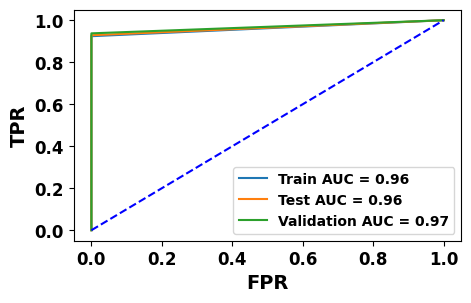

In [74]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/vgg19roc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

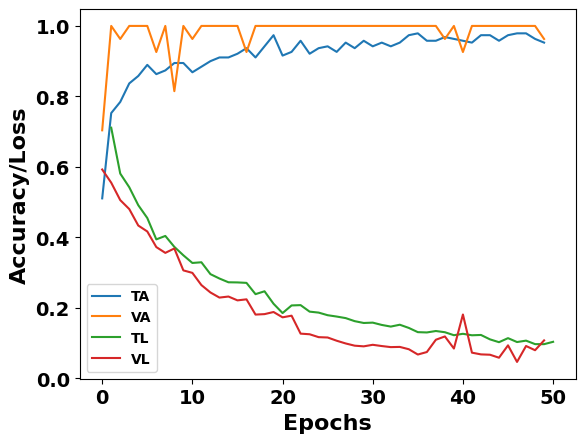

In [75]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/vgg19acc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 57ms/step


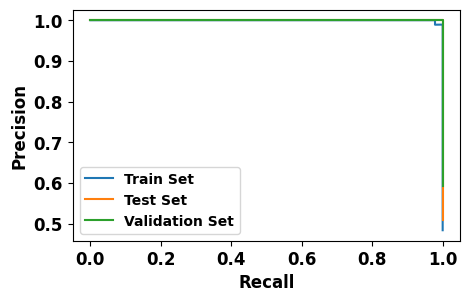

In [76]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/vgg19pr',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


Xception

In [77]:
baseModel=Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [78]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/xceptionmodel_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...


Epoch 1/50
7/7 [==============================] - 6s 282ms/step - loss: 0.5037 - accuracy: 0.7474 - val_loss: 0.1890 - val_accuracy: 1.0000
Epoch 2/50
7/7 [==============================] - 0s 43ms/step - loss: 0.1986 - accuracy: 0.9632 - val_loss: 0.1134 - val_accuracy: 1.0000
Epoch 3/50
7/7 [==============================] - 0s 38ms/step - loss: 0.1315 - accuracy: 0.9789 - val_loss: 0.0773 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 0s 40ms/step - loss: 0.1228 - accuracy: 0.9789 - val_loss: 0.0535 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 0s 43ms/step - loss: 0.0882 - accuracy: 0.9947 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0781 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 42ms/step - loss: 0.0643 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 8/50
7/7 [==========

In [79]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        98
goodcylinder       1.00      1.00      1.00        92

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [80]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [ 0 92]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [81]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 0s 213ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        27
goodcylinder       1.00      1.00      1.00        28

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55

[[27  0]
 [ 0 28]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
[INFO] evaluating network...
1/1 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        11
goodcylinder       1.00      1.00      1.00        16

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

[[11  0]
 [ 0 16]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [82]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 17ms/step

Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Validation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0


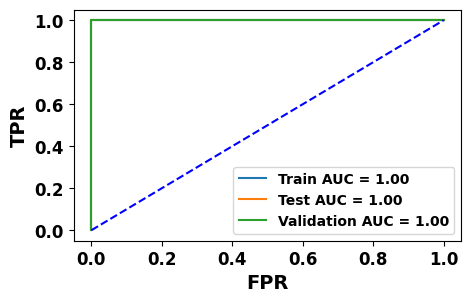

In [83]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/xceptionroc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

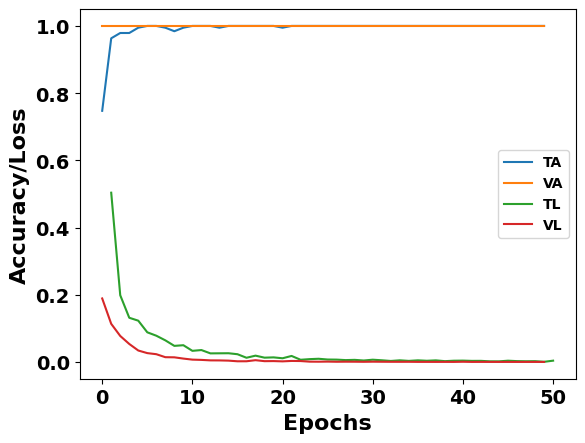

In [84]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/xceptionacc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 41ms/step


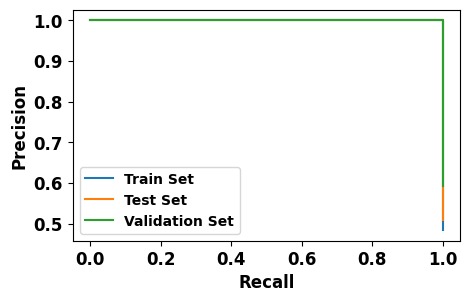

In [85]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/xceptionpr',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


EfficientNetB0

In [86]:
baseModel = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [87]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
opt = SGD(learning_rate=INIT_LR)

[INFO] Compiling model...


In [88]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/netb0model_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...


Epoch 1/50
7/7 [==============================] - 10s 433ms/step - loss: 0.7396 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5926
Epoch 2/50
7/7 [==============================] - 0s 39ms/step - loss: 0.7025 - accuracy: 0.5579 - val_loss: 0.6811 - val_accuracy: 0.5926
Epoch 3/50
7/7 [==============================] - 0s 40ms/step - loss: 0.7099 - accuracy: 0.4737 - val_loss: 0.6859 - val_accuracy: 0.5926
Epoch 4/50
7/7 [==============================] - 0s 45ms/step - loss: 0.6960 - accuracy: 0.4421 - val_loss: 0.6917 - val_accuracy: 0.5926
Epoch 5/50
7/7 [==============================] - 0s 53ms/step - loss: 0.6932 - accuracy: 0.5263 - val_loss: 0.7093 - val_accuracy: 0.4074
Epoch 6/50
7/7 [==============================] - 0s 53ms/step - loss: 0.6912 - accuracy: 0.5158 - val_loss: 0.7046 - val_accuracy: 0.4074
Epoch 7/50
7/7 [==============================] - 0s 54ms/step - loss: 0.6985 - accuracy: 0.5158 - val_loss: 0.6943 - val_accuracy: 0.4074
Epoch 8/50
7/7 [=========

/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 20ms/step


              precision    recall  f1-score   support

 badcylinder       0.52      1.00      0.68        98
goodcylinder       0.00      0.00      0.00        92

    accuracy                           0.52       190
   macro avg       0.26      0.50      0.34       190
weighted avg       0.27      0.52      0.35       190



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [92  0]]
acc: 0.5158
sensitivity: 1.0000
specificity: 0.0000


In [91]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[INFO] evaluating network...


2/2 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

 badcylinder       0.49      1.00      0.66        27
goodcylinder       0.00      0.00      0.00        28

    accuracy                           0.49        55
   macro avg       0.25      0.50      0.33        55
weighted avg       0.24      0.49      0.32        55

[[27  0]
 [28  0]]
acc: 0.4909
sensitivity: 1.0000
specificity: 0.0000
[INFO] evaluating network...
1/1 [==============================] - 0s 60ms/step


/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

              precision    recall  f1-score   support

 badcylinder       0.41      1.00      0.58        11
goodcylinder       0.00      0.00      0.00        16

    accuracy                           0.41        27
   macro avg       0.20      0.50      0.29        27
weighted avg       0.17      0.41      0.24        27

[[11  0]
 [16  0]]
acc: 0.4074
sensitivity: 1.0000
specificity: 0.0000


/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 22ms/step

Training Metrics:
Accuracy: 0.5157894736842106
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.5703194321206744
mAP: 0.528339390676179

Validation Metrics:
Accuracy: 0.4074074074074074
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.625
mAP: 0.6718013468013468

Test Metrics:
Accuracy: 0.4909090909090909
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.4457671957671957
mAP: 0.48213447842480106


/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


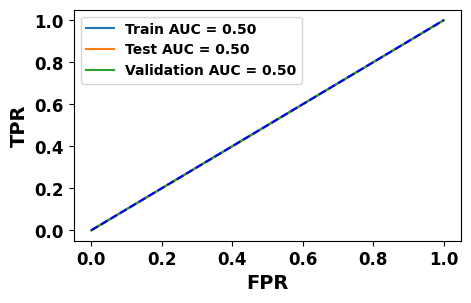

In [93]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/netboroc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

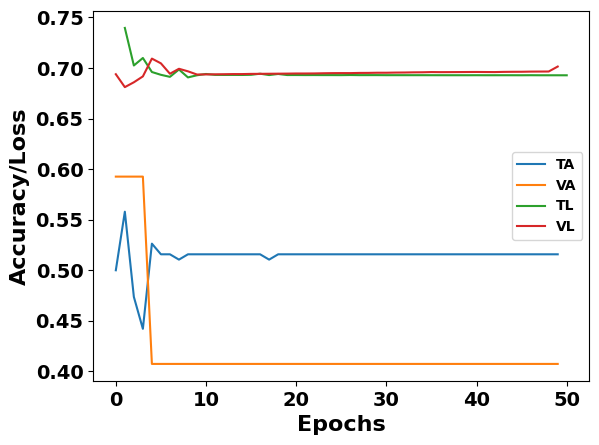

In [94]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/netboacc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 60ms/step


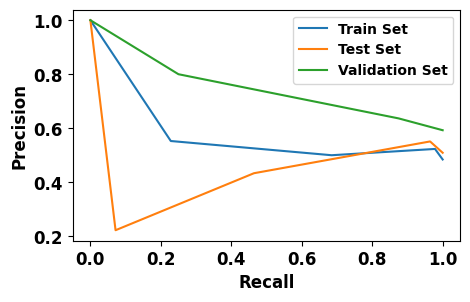

In [95]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/netbopr',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


EfficientNetB7

In [96]:
baseModel = EfficientNetB7(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [97]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
opt = SGD(learning_rate=INIT_LR)

[INFO] Compiling model...


In [98]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/netb7model_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...


Epoch 1/50
7/7 [==============================] - 31s 1s/step - loss: 0.8134 - accuracy: 0.4842 - val_loss: 0.6932 - val_accuracy: 0.4074
Epoch 2/50
7/7 [==============================] - 1s 98ms/step - loss: 0.6933 - accuracy: 0.4842 - val_loss: 0.6928 - val_accuracy: 0.5926
Epoch 3/50
7/7 [==============================] - 1s 95ms/step - loss: 0.6957 - accuracy: 0.4842 - val_loss: 0.6928 - val_accuracy: 0.5926
Epoch 4/50
7/7 [==============================] - 1s 94ms/step - loss: 0.6932 - accuracy: 0.4842 - val_loss: 0.6929 - val_accuracy: 0.5926
Epoch 5/50
7/7 [==============================] - 1s 102ms/step - loss: 0.6931 - accuracy: 0.4895 - val_loss: 0.7041 - val_accuracy: 0.4074
Epoch 6/50
7/7 [==============================] - 1s 96ms/step - loss: 0.6916 - accuracy: 0.5421 - val_loss: 0.7083 - val_accuracy: 0.4074
Epoch 7/50
7/7 [==============================] - 1s 97ms/step - loss: 0.7014 - accuracy: 0.4421 - val_loss: 0.6930 - val_accuracy: 0.5926
Epoch 8/50
7/7 [===========

/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 67ms/step
              precision    recall  f1-score   support

 badcylinder       0.52      1.00      0.68        98
goodcylinder       0.00      0.00      0.00        92

    accuracy                           0.52       190
   macro avg       0.26      0.50      0.34       190
weighted avg       0.27      0.52      0.35       190



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [92  0]]
acc: 0.5158
sensitivity: 1.0000
specificity: 0.0000


In [101]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...


2/2 [==============================] - 0s 89ms/step
              precision    recall  f1-score   support

 badcylinder       0.49      1.00      0.66        27
goodcylinder       0.00      0.00      0.00        28

    accuracy                           0.49        55
   macro avg       0.25      0.50      0.33        55
weighted avg       0.24      0.49      0.32        55



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[27  0]
 [28  0]]
acc: 0.4909
sensitivity: 1.0000
specificity: 0.0000


In [103]:
# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 [==============================] - 0s 89ms/step


              precision    recall  f1-score   support

 badcylinder       0.41      1.00      0.58        11
goodcylinder       0.00      0.00      0.00        16

    accuracy                           0.41        27
   macro avg       0.20      0.50      0.29        27
weighted avg       0.17      0.41      0.24        27



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[11  0]
 [16  0]]
acc: 0.4074
sensitivity: 1.0000
specificity: 0.0000


In [105]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 61ms/step

Training Metrics:
Accuracy: 0.5157894736842106
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.5
mAP: 0.4842105263157895

Validation Metrics:
Accuracy: 0.4074074074074074
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.5
mAP: 0.5925925925925926

Test Metrics:
Accuracy: 0.4909090909090909
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.5
mAP: 0.509090909090909


/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


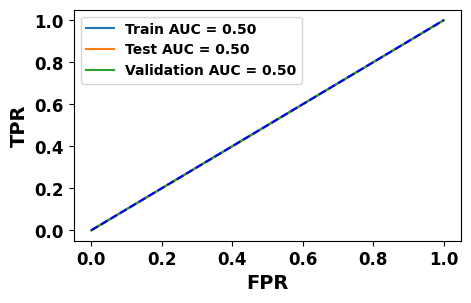

In [106]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/b7roc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

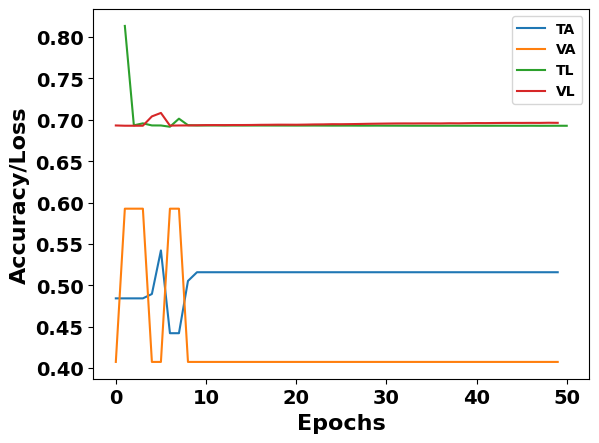

In [107]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/b7acc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 68ms/step


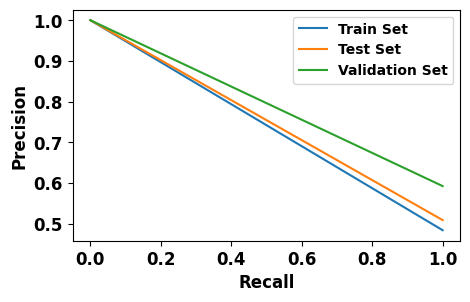

In [108]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/b7pr',dpi=200, bbox_inches='tight')

# Show plot
plt.show()


NASNetLarge

In [109]:
c
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [110]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
opt = SGD(learning_rate=INIT_LR)

[INFO] Compiling model...


In [111]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/nasnetlargemodel_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...


Epoch 1/50
7/7 [==============================] - 30s 2s/step - loss: 0.4165 - accuracy: 0.8526 - val_loss: 0.0587 - val_accuracy: 0.9630
Epoch 2/50
7/7 [==============================] - 1s 111ms/step - loss: 0.1867 - accuracy: 0.9316 - val_loss: 0.1134 - val_accuracy: 0.8889
Epoch 3/50
7/7 [==============================] - 1s 106ms/step - loss: 0.0904 - accuracy: 0.9632 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 1s 108ms/step - loss: 0.0857 - accuracy: 0.9632 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 1s 112ms/step - loss: 0.0329 - accuracy: 0.9947 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 1s 92ms/step - loss: 0.0418 - accuracy: 0.9842 - val_loss: 0.0316 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 1s 111ms/step - loss: 0.0483 - accuracy: 0.9842 - val_loss: 0.0525 - val_accuracy: 0.9630
Epoch 8/50
7/7 [=======

In [112]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        98
goodcylinder       1.00      1.00      1.00        92

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [113]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [ 0 92]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [114]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...


2/2 [==============================] - 0s 106ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        27
goodcylinder       1.00      1.00      1.00        28

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



In [115]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[27  0]
 [ 0 28]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [116]:
# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

[INFO] evaluating network...


1/1 [==============================] - 0s 71ms/step
              precision    recall  f1-score   support

 badcylinder       1.00      1.00      1.00        11
goodcylinder       1.00      1.00      1.00        16

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [117]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[11  0]
 [ 0 16]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [118]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 58ms/step

Training Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Validation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0

Test Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MCC: 1.0
Kappa: 1.0
AUC: 1.0
mAP: 1.0


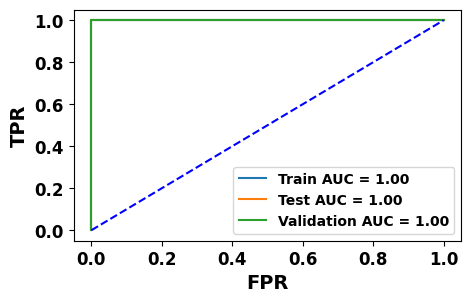

In [119]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/nasnetroc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

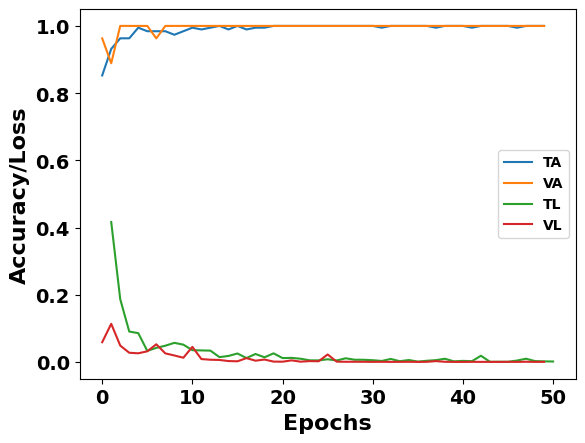

In [120]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/nasnetacc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 78ms/step


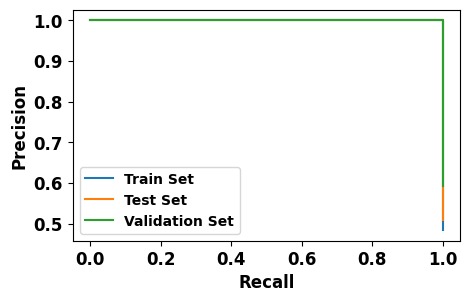

In [121]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})

plt.savefig('/data/ahsan/additive3d/result1/rmsprop/nasnetpr',dpi=200, bbox_inches='tight')
# Show plot
plt.show()


EfficientNetV2M

In [122]:
baseModel= EfficientNetV2M(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [123]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
#opt = Adam(learning_rate=INIT_LR)
opt = SGD(learning_rate=INIT_LR)

[INFO] Compiling model...


In [124]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, average_precision_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Assuming other variables (INIT_LR, EPOCHS, trainAug, trainX, trainY, validationX, validationY, BS, model) are defined
# Compile the model with the Adam optimizer
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR)
# opt = SGD(learning_rate=INIT_LR)
#opt = RMSprop(learning_rate=INIT_LR)
# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
t1 = time.process_time()
H = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, validation_data=(validationX, validationY))
t2 = time.process_time()
print("Process time:", t2 - t1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    map = average_precision_score(y_true, y_score)  # mAP score
    sensitivity = recall # In binary classification, recall of the positive class is also known as "sensitivity"
    specificity = recall_score(y_true, y_pred, pos_label=0) # Specificity calculation
    return accuracy, precision, recall, f1, mcc, kappa, auc, map, sensitivity, specificity

# Function to calculate confusion matrix
def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Predictions for training, validation, and test datasets
trainY_pred = model.predict(trainX)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred = model.predict(validationX)
validationY_pred_binary = np.round(validationY_pred)
testY_pred = model.predict(testX)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics and confusion matrices
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:,1])
train_cm = calculate_confusion_matrix(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1))

validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:,1])
validation_cm = calculate_confusion_matrix(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1))

test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:,1])
test_cm = calculate_confusion_matrix(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1))

# Metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, validation_metrics, test_metrics], 
                          index=["Train", "Validation", "Test"],
                          columns=["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP", "Sensitivity", "Specificity"])

# Save to Excel
with pd.ExcelWriter('/data/ahsan/additive3d/result1/rmsprop/v2mmodel_results.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics')
    train_cm.to_excel(writer, sheet_name='Train Confusion Matrix')
    validation_cm.to_excel(writer, sheet_name='Validation Confusion Matrix')
    test_cm.to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to model_results.xlsx")


[INFO] Compiling model...
[INFO] compiling model...
[INFO] training head...


Epoch 1/50
7/7 [==============================] - 33s 1s/step - loss: 0.7733 - accuracy: 0.4895 - val_loss: 0.7000 - val_accuracy: 0.4074
Epoch 2/50
7/7 [==============================] - 0s 63ms/step - loss: 0.6979 - accuracy: 0.5211 - val_loss: 0.6809 - val_accuracy: 0.5926
Epoch 3/50
7/7 [==============================] - 0s 63ms/step - loss: 0.7010 - accuracy: 0.5053 - val_loss: 0.6960 - val_accuracy: 0.4074
Epoch 4/50
7/7 [==============================] - 0s 71ms/step - loss: 0.7007 - accuracy: 0.4947 - val_loss: 0.7158 - val_accuracy: 0.4074
Epoch 5/50
7/7 [==============================] - 0s 73ms/step - loss: 0.6959 - accuracy: 0.5158 - val_loss: 0.6984 - val_accuracy: 0.4074
Epoch 6/50
7/7 [==============================] - 0s 69ms/step - loss: 0.6906 - accuracy: 0.5579 - val_loss: 0.6999 - val_accuracy: 0.4074
Epoch 7/50
7/7 [==============================] - 0s 75ms/step - loss: 0.6927 - accuracy: 0.5105 - val_loss: 0.6766 - val_accuracy: 0.5926
Epoch 8/50
7/7 [============

/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

6/6 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

 badcylinder       0.52      1.00      0.68        98
goodcylinder       0.00      0.00      0.00        92

    accuracy                           0.52       190
   macro avg       0.26      0.50      0.34       190
weighted avg       0.27      0.52      0.35       190



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[98  0]
 [92  0]]
acc: 0.5158
sensitivity: 1.0000
specificity: 0.0000


In [127]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
testpredict = np.argmax(predIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
2/2 [==============================] - 0s 226ms/step
              precision    recall  f1-score   support

 badcylinder       0.49      1.00      0.66        27
goodcylinder       0.00      0.00      0.00        28

    accuracy                           0.49        55
   macro avg       0.25      0.50      0.33        55
weighted avg       0.24      0.49      0.32        55



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[27  0]
 [28  0]]
acc: 0.4909
sensitivity: 1.0000
specificity: 0.0000


In [129]:
# make predictions on the testing set
print("[INFO] evaluating network...")
valpredIdys = model.predict(validationX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
valpredict = np.argmax(valpredIdys, axis=1)
# show a nicely formatted classification report
print(classification_report(validationY.argmax(axis=1), valpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 [==============================] - 0s 79ms/step
              precision    recall  f1-score   support

 badcylinder       0.41      1.00      0.58        11
goodcylinder       0.00      0.00      0.00        16

    accuracy                           0.41        27
   macro avg       0.20      0.50      0.29        27
weighted avg       0.17      0.41      0.24        27



/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(validationY.argmax(axis=1), valpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[11  0]
 [16  0]]
acc: 0.4074
sensitivity: 1.0000
specificity: 0.0000


In [131]:
# Assuming calculate_metrics function is defined as before

# Predictions for each dataset
trainY_pred = model.predict(trainX, batch_size=BS)
validationY_pred = model.predict(validationX, batch_size=BS)
testY_pred = model.predict(testX, batch_size=BS)

# Convert predictions to binary (if necessary)
trainY_pred_binary = np.round(trainY_pred)
validationY_pred_binary = np.round(validationY_pred)
testY_pred_binary = np.round(testY_pred)

# Calculate metrics for each dataset
train_metrics = calculate_metrics(trainY.argmax(axis=1), trainY_pred_binary.argmax(axis=1), trainY_pred[:, 1])
validation_metrics = calculate_metrics(validationY.argmax(axis=1), validationY_pred_binary.argmax(axis=1), validationY_pred[:, 1])
test_metrics = calculate_metrics(testY.argmax(axis=1), testY_pred_binary.argmax(axis=1), testY_pred[:, 1])

# Print metrics for training, validation, and test data
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Kappa", "AUC", "mAP"]
print("\nTraining Metrics:")
for name, value in zip(metrics_names, train_metrics):
    print(f"{name}: {value}")

print("\nValidation Metrics:")
for name, value in zip(metrics_names, validation_metrics):
    print(f"{name}: {value}")

print("\nTest Metrics:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value}")


2/2 [==============================] - 0s 37ms/step

Training Metrics:
Accuracy: 0.5157894736842106
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.8908606921029282
mAP: 0.9132766421934545

Validation Metrics:
Accuracy: 0.4074074074074074
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.8579545454545454
mAP: 0.9118256453299023

Test Metrics:
Accuracy: 0.4909090909090909
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MCC: 0.0
Kappa: 0.0
AUC: 0.9722222222222222
mAP: 0.9760508484417403


/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/rifat/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


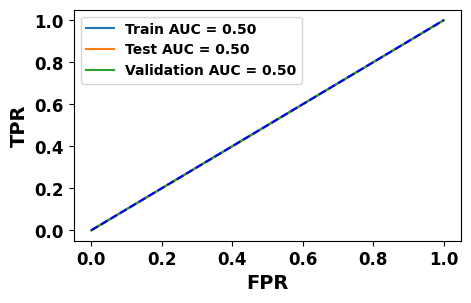

In [132]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 3))

# Calculate ROC for training set
fpr1, tpr1, _ = roc_curve(np.argmax(trainY, axis=1), np.argmax(predIdxs, axis=1))
area_under_curve1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Train AUC = {:.2f}'.format(area_under_curve1))

# Calculate ROC for testing set
fpr2, tpr2, _ = roc_curve(np.argmax(testY, axis=1), np.argmax(predIdys, axis=1))
area_under_curve2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Test AUC = {:.2f}'.format(area_under_curve2))

# Calculate ROC for validation set
fpr3, tpr3, _ = roc_curve(validationY.argmax(axis=1), np.argmax(valpredIdys, axis=1))
area_under_curve3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Validation AUC = {:.2f}'.format(area_under_curve3))

# Plotting the random line
random_probs = [0 for _ in range(len(validationY.ravel()))]
p_fpr, p_tpr, _ = roc_curve(validationY.ravel(), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Labels and settings
plt.xlabel('FPR', fontsize=14, fontweight='bold')
plt.ylabel('TPR', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, weight='bold', fontsize=12)
plt.yticks(rotation=0, weight='bold', fontsize=12)
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/v2mroc',dpi=200, bbox_inches='tight')
plt.show()



<Figure size 500x300 with 0 Axes>

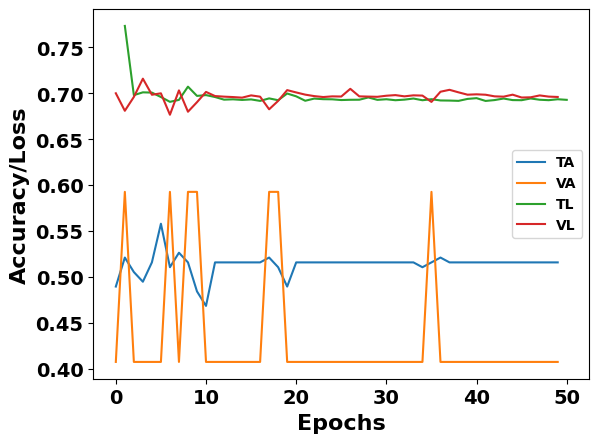

In [133]:
#import seaborn as sns
#plt.style.use('default')
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize = (5, 3))
#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VL')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'weight': 'bold', 'size': 10})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('/data/ahsan/additive3d/result1/rmsprop/v2macc',dpi=200, bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 68ms/step


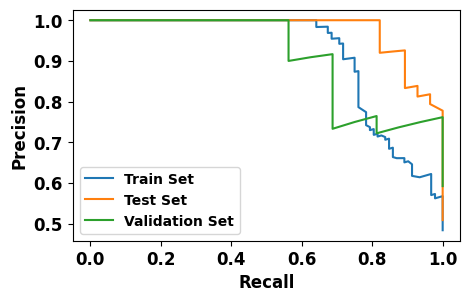

In [134]:
# Assuming model, trainX, testX, validationX are already defined and properly preprocessed
trainY_pred = model.predict(trainX)
testY_pred = model.predict(testX)
validationY_pred = model.predict(validationX)
fig = plt.figure(figsize = (5, 3))
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, set_name):
    # Assuming y_true is one-hot encoded, extract the labels for the positive class
    y_true_binary = y_true[:, 1] if y_true.ndim > 1 else y_true

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)

    # Plot the precision-recall curves
    plt.plot(recall, precision, label=f'{set_name} Set')

# Assuming trainY, testY, validationY are your true labels (one-hot encoded)
# Assuming the positive class predictions are in the second column of your prediction arrays
plot_precision_recall_curve(trainY, trainY_pred[:, 1], 'Train')
plot_precision_recall_curve(testY, testY_pred[:, 1], 'Test')
plot_precision_recall_curve(validationY, validationY_pred[:, 1], 'Validation')

# Axis labels
plt.xlabel('Recall', fontsize=12, fontdict=dict(weight='bold'))
plt.ylabel('Precision', fontsize=12, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
# Show legend
plt.legend(prop={'weight': 'bold', 'size': 10})

plt.savefig('/data/ahsan/additive3d/result1/rmsprop/v2mpr',dpi=200, bbox_inches='tight')
# Show plot
plt.show()


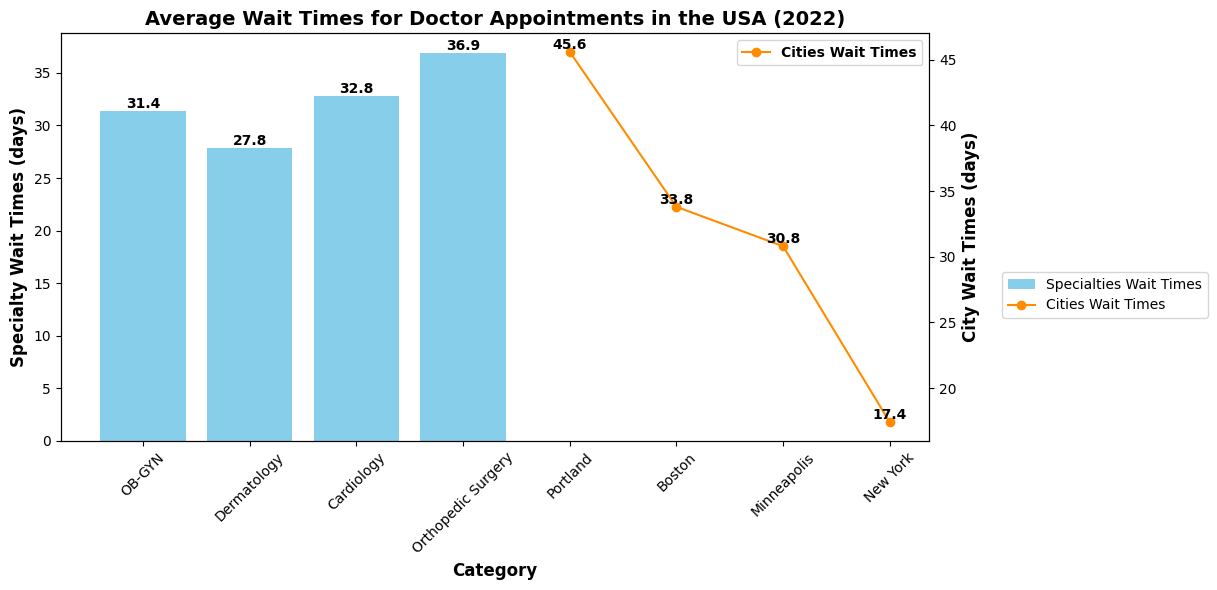

In [8]:
import matplotlib.pyplot as plt

# Data setup
specialties = ['OB-GYN', 'Dermatology', 'Cardiology', 'Orthopedic Surgery']
wait_times_specialties = [31.4, 26 * 1.07, 26 * 1.26, 26 * 1.42]  # Calculated based on percentage increases
cities = ['Portland', 'Boston', 'Minneapolis', 'New York']
wait_times_cities = [45.6, 33.8, 30.8, 17.4]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for specialties
bars = ax1.bar(specialties, wait_times_specialties, color='skyblue', label='Specialties Wait Times')

# Adding text labels for the bar chart
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), verticalalignment='bottom', 
             ha='center', fontweight='bold', fontsize=10)

# Setting the second y-axis for city wait times
ax2 = ax1.twinx()
ax2.plot(cities, wait_times_cities, color='darkorange', marker='o', label='Cities Wait Times')

# Adding text labels for the line chart
for i, txt in enumerate(wait_times_cities):
    ax2.text(cities[i], wait_times_cities[i], f'{round(txt, 1)}', fontweight='bold', ha='center', va='bottom')

# Styling
ax1.set_xlabel('Category', fontweight='bold', fontsize=12)
ax1.set_ylabel('Specialty Wait Times (days)', fontweight='bold', fontsize=12)
ax2.set_ylabel('City Wait Times (days)', fontweight='bold', fontsize=12)
ax1.set_title('Average Wait Times for Doctor Appointments in the USA (2022)', fontweight='bold', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=10, labelcolor='black', labelrotation=45)
ax1.tick_params(axis='y', labelsize=10, labelcolor='black')
ax2.tick_params(axis='y', labelsize=10, labelcolor='black')
plt.legend(prop={'weight': 'bold', 'size': 10})
# Legend
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True)

plt.show()


C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\46295350.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(specialties + cities, fontsize=14, fontweight='bold', rotation=45)
C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\46295350.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(tick) for tick in ax1.get_yticks()], fontsize=14, fontweight='bold')
C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\46295350.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(tick) for tick in ax2.get_yticks()], fontsize=14, fontweight='bold')


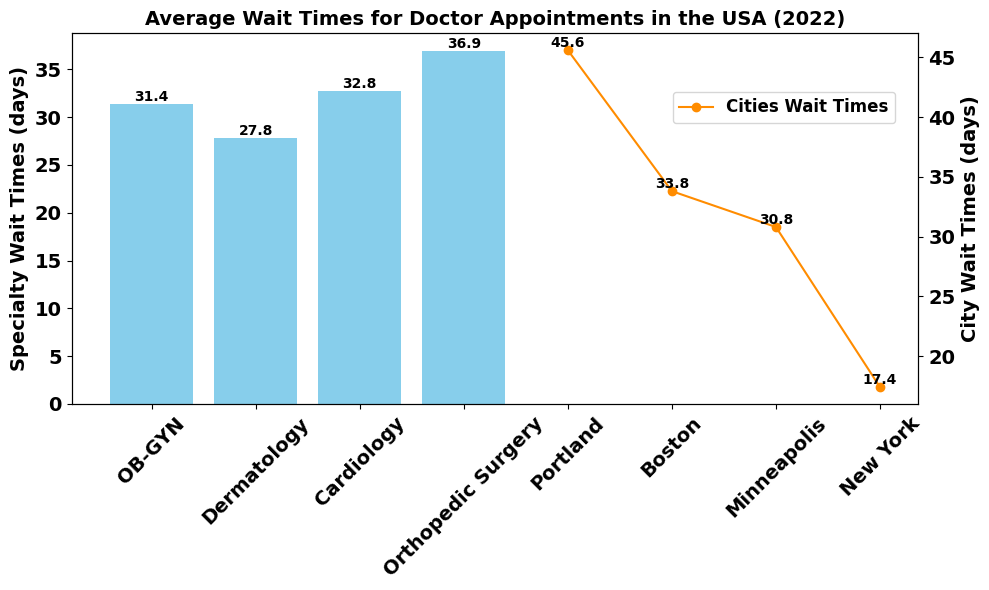

In [22]:
import matplotlib.pyplot as plt

# Data setup
specialties = ['OB-GYN', 'Dermatology', 'Cardiology', 'Orthopedic Surgery']
wait_times_specialties = [31.4, 26 * 1.07, 26 * 1.26, 26 * 1.42]
cities = ['Portland', 'Boston', 'Minneapolis', 'New York']
wait_times_cities = [45.6, 33.8, 30.8, 17.4]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for specialties
bars = ax1.bar(specialties, wait_times_specialties, color='skyblue', label='Specialties Wait Times')

# Adding text labels for the bar chart
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), verticalalignment='bottom', 
             ha='center', fontweight='bold', fontsize=10)

# Setting the second y-axis for city wait times
ax2 = ax1.twinx()
ax2.plot(cities, wait_times_cities, color='darkorange', marker='o', label='Cities Wait Times')

# Adding text labels for the line chart
for i, txt in enumerate(wait_times_cities):
    ax2.text(cities[i], wait_times_cities[i], f'{round(txt, 1)}', fontweight='bold', ha='center', va='bottom')

# Styling
ax1.set_ylabel('Specialty Wait Times (days)', fontweight='bold', fontsize=14)
ax2.set_ylabel('City Wait Times (days)', fontweight='bold', fontsize=14)
ax1.set_title('Average Wait Times for Doctor Appointments in the USA (2022)', fontweight='bold', fontsize=14)

# Correcting tick labels to bold
ax1.set_xticklabels(specialties + cities, fontsize=14, fontweight='bold', rotation=45)
ax1.set_yticklabels([int(tick) for tick in ax1.get_yticks()], fontsize=14, fontweight='bold')
ax2.set_yticklabels([int(tick) for tick in ax2.get_yticks()], fontsize=14, fontweight='bold')

# Legend
legend = plt.legend(prop={'weight': 'bold', 'size': 12}, loc='center left', bbox_to_anchor=(.7, 0.8))

plt.tight_layout()
plt.show()


C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\1911142482.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(specialties, fontsize=14, fontweight='bold', rotation=45)
C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\1911142482.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(tick) for tick in ax1.get_yticks()], fontsize=14, fontweight='bold')


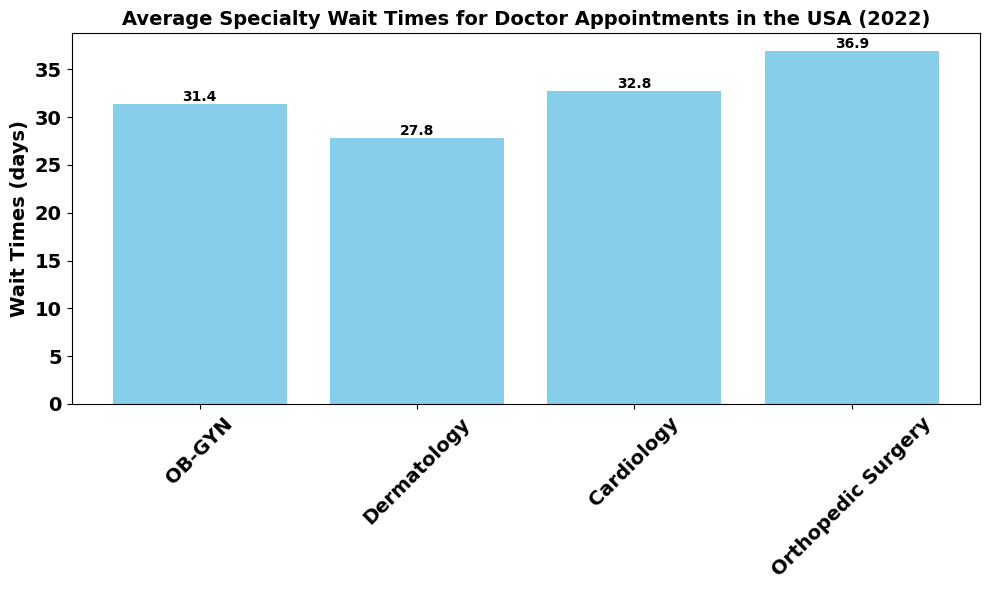

C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\1911142482.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(cities, fontsize=14, fontweight='bold', rotation=45)
C:\Users\dvv3455\AppData\Local\Temp\ipykernel_40188\1911142482.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(tick) for tick in ax2.get_yticks()], fontsize=14, fontweight='bold')


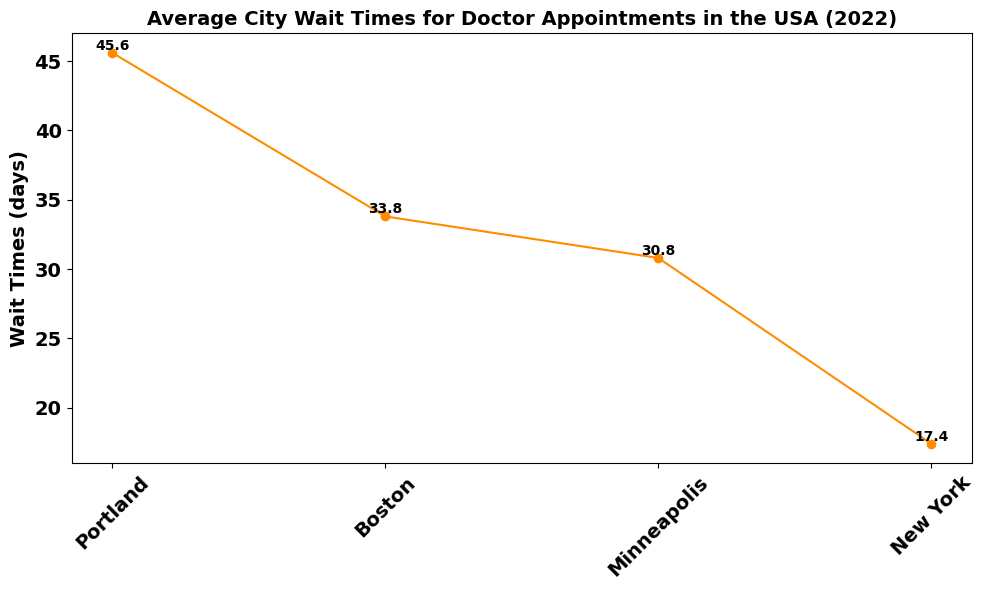

In [23]:
import matplotlib.pyplot as plt

# Data setup
specialties = ['OB-GYN', 'Dermatology', 'Cardiology', 'Orthopedic Surgery']
wait_times_specialties = [31.4, 26 * 1.07, 26 * 1.26, 26 * 1.42]
cities = ['Portland', 'Boston', 'Minneapolis', 'New York']
wait_times_cities = [45.6, 33.8, 30.8, 17.4]

# Plotting for Specialties
fig1, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(specialties, wait_times_specialties, color='skyblue', label='Specialties Wait Times')
# Adding text labels for the bar chart
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), verticalalignment='bottom', 
             ha='center', fontweight='bold', fontsize=10)
# Styling
ax1.set_ylabel('Wait Times (days)', fontweight='bold', fontsize=14)
ax1.set_title('Average Specialty Wait Times for Doctor Appointments in the USA (2022)', fontweight='bold', fontsize=14)
ax1.set_xticklabels(specialties, fontsize=14, fontweight='bold', rotation=45)
ax1.set_yticklabels([int(tick) for tick in ax1.get_yticks()], fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plotting for Cities
fig2, ax2 = plt.subplots(figsize=(10, 6))
lines = ax2.plot(cities, wait_times_cities, color='darkorange', marker='o', label='Cities Wait Times')
# Adding text labels for the line chart
for i, txt in enumerate(wait_times_cities):
    ax2.text(cities[i], txt, f'{round(txt, 1)}', fontweight='bold', ha='center', va='bottom')
# Styling
ax2.set_ylabel('Wait Times (days)', fontweight='bold', fontsize=14)
ax2.set_title('Average City Wait Times for Doctor Appointments in the USA (2022)', fontweight='bold', fontsize=14)
ax2.set_xticklabels(cities, fontsize=14, fontweight='bold', rotation=45)
ax2.set_yticklabels([int(tick) for tick in ax2.get_yticks()], fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
